# June 23

In [1]:
import os
from dotenv import load_dotenv
from pathlib import Path
from datasets import load_dataset
from autogluon.timeseries import TimeSeriesDataFrame
from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X
from tabpfn_time_series.plot import plot_actual_ts
import matplotlib.pyplot as plt
from tabpfn_time_series import FeatureTransformer
from tabpfn_time_series.features import (
    RunningIndexFeature,
    CalendarFeature,
    AutoSeasonalFeature,
)
from patch_features import (PatchingFeature, LinearTrendFeature, 
                            QuadraticTrendFeature, CubicTrendFeature, 
                            QuarticTrendFeature, 
                            AmplitudeModulationTrendFeature,
                            PolynomialTrendFeature, create_lag_matrix)
from save_plot import quick_mase_evaluation
import numpy as np


In [2]:
import torch
series = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).to(torch.float32)
window_size = 3
lag_matrix = create_lag_matrix(series, window_size)
print(lag_matrix, lag_matrix.shape)

tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, 1.],
        [nan, 1., 2.],
        [1., 2., 3.],
        [2., 3., 4.],
        [3., 4., 5.],
        [4., 5., 6.],
        [5., 6., 7.]]) torch.Size([10, 3])


In [6]:
lag_median = lag_matrix.median(dim=1).values.reshape(-1,1)
lag_median
# print(lag_median, lag_median.shape)



tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.]])

# One test case

- Other thought: linear modulation - y multiply by a linear trend

- load the dataset

In [1]:
# !python script_detrend_y.py --degree 1 --save_results

In [2]:
# Extract the data passed into PFN (monash_tourism_monthly id: 4)

import os
from dotenv import load_dotenv
from pathlib import Path
from datasets import load_dataset
from autogluon.timeseries import TimeSeriesDataFrame
from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X
from tabpfn_time_series.plot import plot_actual_ts
import matplotlib.pyplot as plt
from tabpfn_time_series import FeatureTransformer
from tabpfn_time_series.features import (
    RunningIndexFeature,
    CalendarFeature,
    AutoSeasonalFeature,
)
from patch_features import (PatchingFeature, LinearTrendFeature, 
                            QuadraticTrendFeature, CubicTrendFeature, 
                            QuarticTrendFeature, 
                            AmplitudeModulationTrendFeature,
                            PolynomialTrendFeature)
from save_plot import quick_mase_evaluation
import numpy as np


# Select the dataset
load_dotenv()
root_output_dir = Path("plots")
root_output_dir.mkdir(parents=True, exist_ok=True)
dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24}, # {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
    "electricity_15min": {"prediction_length": 48},
}
dataset_choice = "monash_tourism_monthly"
num_time_series_subset = 4


## Plotting

amplitude_modulation_trend


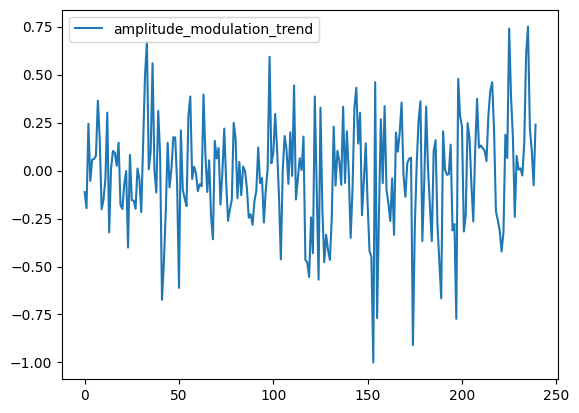

In [12]:
# Loop through each train_tsdf.columns and plot them all in one figure with different colors and alpha
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

for col in train_tsdf.columns:
    if col == 'target':
        continue
    elif col == 'year' or col=="running_index":
        continue
    elif "sin" in col or "cos" in col:
        continue
    print(col)
    plt.plot(np.array(train_tsdf[col]), alpha=1, label=col)
    # plt.plot(np.array(train_tsdf[col]), alpha=0.5, label=col)
plt.legend()
plt.show()

# train_tsdf["linear_trend"]



## Vanilla TabPFNTS

GPU 0:: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


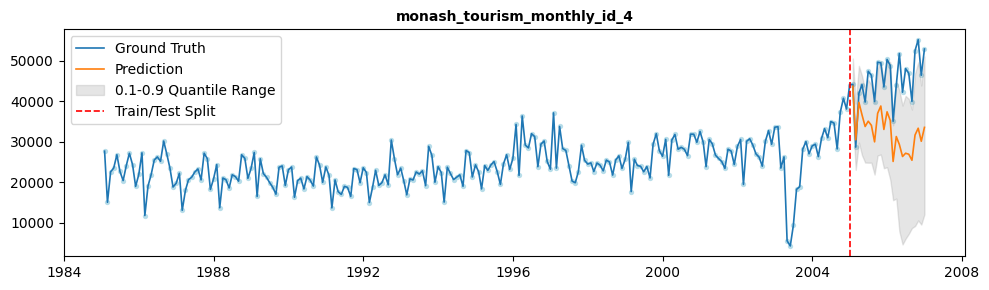

(   item_id  mase_score
 0        4     3.75062
 1  AVERAGE     3.75062,
 Index(['target', 'running_index', 'year', 'second_of_minute_sin',
        'second_of_minute_cos', 'minute_of_hour_sin', 'minute_of_hour_cos',
        'hour_of_day_sin', 'hour_of_day_cos', 'day_of_week_sin',
        'day_of_week_cos', 'day_of_month_sin', 'day_of_month_cos',
        'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin',
        'week_of_year_cos', 'month_of_year_sin', 'month_of_year_cos', 'sin_#0',
        'cos_#0', 'sin_#1', 'cos_#1', 'sin_#2', 'cos_#2', 'sin_#3', 'cos_#3',
        'sin_#4', 'cos_#4'],
       dtype='object'))

In [18]:
# Load and plot data
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)
tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
prediction_length = dataset_metadata[dataset_choice]['prediction_length']
tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[[num_time_series_subset]])]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

# plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

# Feature engineering
PATCH = False
if PATCH:
    selected_features = [
        RunningIndexFeature(),
        CalendarFeature(),
        AutoSeasonalFeature(),
        PatchingFeature(),
    ]
else:
    selected_features = [
        RunningIndexFeature(),
        CalendarFeature(),
        AutoSeasonalFeature(),
    ]

feature_transformer = FeatureTransformer(selected_features)
train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)


# Prediction
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode
predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.LOCAL,
)
pred = predictor.predict(train_tsdf, test_tsdf)


# Plotting
from tabpfn_time_series.plot import plot_pred_and_actual_ts
output_dir = root_output_dir / "patching_test"
output_dir.mkdir(parents=True, exist_ok=True)
plot_pred_and_actual_ts(pred, train_tsdf, test_tsdf_ground_truth, 
                        item_ids=list(train_tsdf.item_ids), show_points=True,
                        title=f"{dataset_choice}_id_{num_time_series_subset}",
                        # save_path=output_dir / f"{dataset_choice.replace('/', '-')}.pdf"
                        )

# MASE
final_results = quick_mase_evaluation(train_tsdf, test_tsdf_ground_truth, 
                                      pred, prediction_length,
                                      )
final_results,  train_tsdf.columns
# , train_tsdf.head()


### Plot of each features

running_index
linear_trend


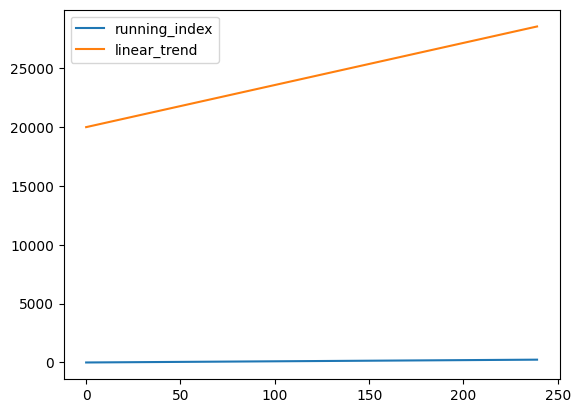

item_id  timestamp 
4        1985-01-31    20012.089903
         1985-02-28    20047.901424
         1985-03-31    20083.712945
         1985-04-30    20119.524466
         1985-05-31    20155.335987
                           ...     
         2004-08-31    28427.797346
         2004-09-30    28463.608867
         2004-10-31    28499.420388
         2004-11-30    28535.231909
         2004-12-31    28571.043430
Name: linear_trend, Length: 240, dtype: float64

In [6]:
# Loop through each train_tsdf.columns and plot them all in one figure with different colors and alpha
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

for col in train_tsdf.columns:
    if col == 'target' or col == 'year':
        continue
    elif "sin" in col or "cos" in col:
        continue
    print(col)
    plt.plot(np.array(train_tsdf[col]), alpha=1, label=col)
    # plt.plot(np.array(train_tsdf[col]), alpha=0.5, label=col)
plt.legend()
plt.show()

train_tsdf["linear_trend"]



## No detrend

GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


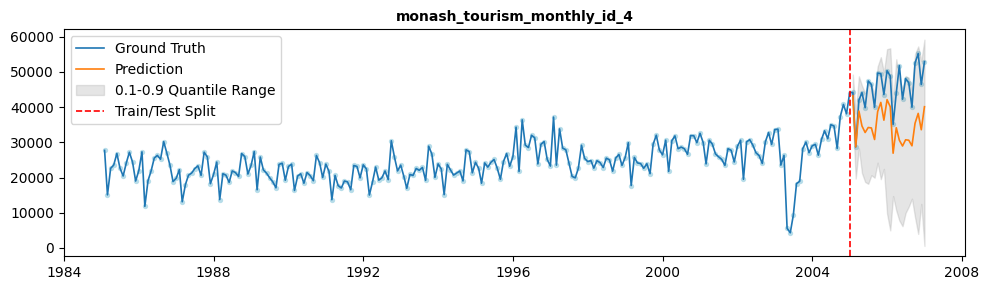

(   item_id  mase_score
 0        4    3.159783
 1  AVERAGE    3.159783,
 Index(['target', 'running_index', 'year', 'second_of_minute_sin',
        'second_of_minute_cos', 'minute_of_hour_sin', 'minute_of_hour_cos',
        'hour_of_day_sin', 'hour_of_day_cos', 'day_of_week_sin',
        'day_of_week_cos', 'day_of_month_sin', 'day_of_month_cos',
        'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin',
        'week_of_year_cos', 'month_of_year_sin', 'month_of_year_cos', 'sin_#0',
        'cos_#0', 'sin_#1', 'cos_#1', 'sin_#2', 'cos_#2', 'sin_#3', 'cos_#3',
        'sin_#4', 'cos_#4'],
       dtype='object'))

In [10]:
# Load and plot data
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)
tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
prediction_length = dataset_metadata[dataset_choice]['prediction_length']
tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[[num_time_series_subset]])]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

# plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

# Feature engineering
PATCH = False
if PATCH:
    selected_features = [
        RunningIndexFeature(),
        CalendarFeature(),
        AutoSeasonalFeature(),
        PatchingFeature(),
    ]
else:
    selected_features = [
        RunningIndexFeature(),
        CalendarFeature(),
        AutoSeasonalFeature({"do_detrend": False}),
    ]

feature_transformer = FeatureTransformer(selected_features)
train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)


# Prediction
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode
predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.LOCAL,
)
pred = predictor.predict(train_tsdf, test_tsdf)


# Plotting
from tabpfn_time_series.plot import plot_pred_and_actual_ts
output_dir = root_output_dir / "patching_test"
output_dir.mkdir(parents=True, exist_ok=True)
plot_pred_and_actual_ts(pred, train_tsdf, test_tsdf_ground_truth, 
                        item_ids=list(train_tsdf.item_ids), show_points=True,
                        title=f"{dataset_choice}_id_{num_time_series_subset}",
                        # save_path=output_dir / f"{dataset_choice.replace('/', '-')}.pdf"
                        )

# MASE
final_results = quick_mase_evaluation(train_tsdf, test_tsdf_ground_truth, 
                                      pred, prediction_length,
                                      )
final_results,  train_tsdf.columns



## Linear Trend


--------------------------------
PRE_DETREND: True, DO_DETREND: True, Z_SCALING: True, CONST: 0.01


GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

   item_id  mase_score
0        4    3.067586
1  AVERAGE    3.067586


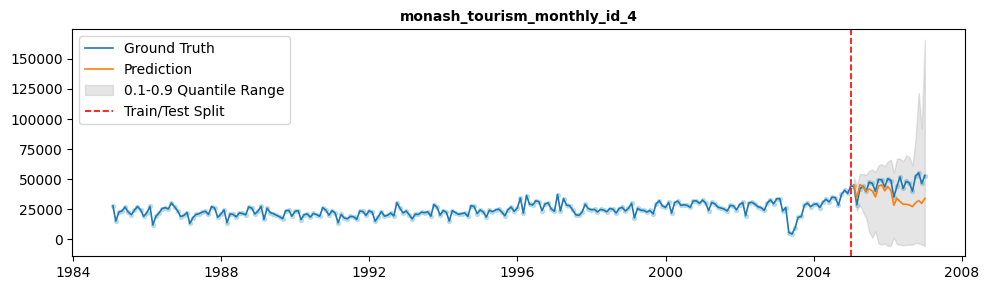


--------------------------------
PRE_DETREND: True, DO_DETREND: True, Z_SCALING: False, CONST: 0.01


GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

   item_id  mase_score
0        4    3.644877
1  AVERAGE    3.644877


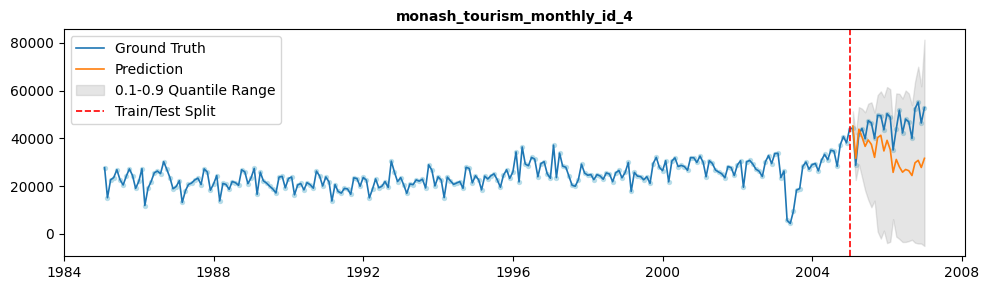


--------------------------------
PRE_DETREND: True, DO_DETREND: False, Z_SCALING: True, CONST: 0.01


GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

   item_id  mase_score
0        4    2.187477
1  AVERAGE    2.187477


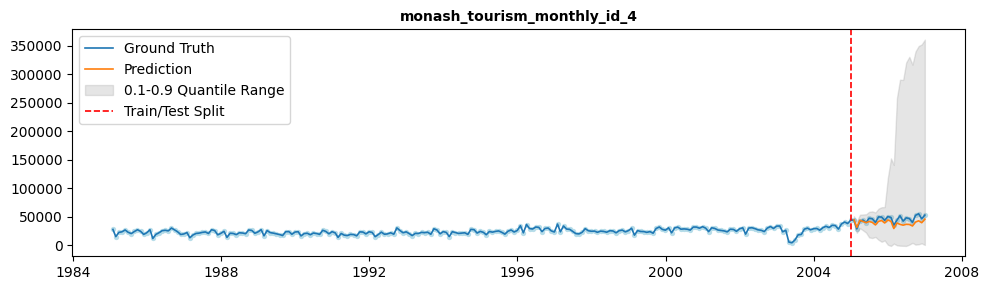


--------------------------------
PRE_DETREND: True, DO_DETREND: False, Z_SCALING: False, CONST: 0.01


GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

   item_id  mase_score
0        4     5.05963
1  AVERAGE     5.05963


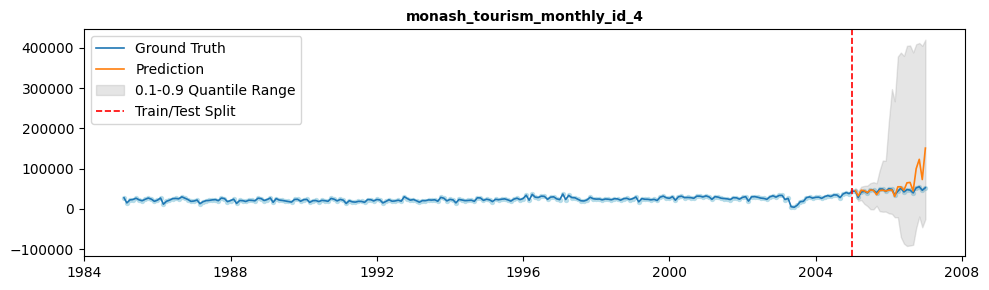


--------------------------------
PRE_DETREND: False, DO_DETREND: True, Z_SCALING: True, CONST: 0.01


GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

   item_id  mase_score
0        4    3.272196
1  AVERAGE    3.272196


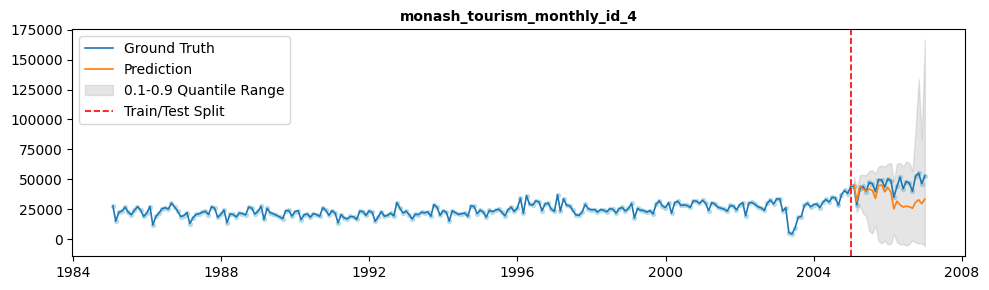


--------------------------------
PRE_DETREND: False, DO_DETREND: True, Z_SCALING: False, CONST: 0.01


GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

   item_id  mase_score
0        4    3.219111
1  AVERAGE    3.219111


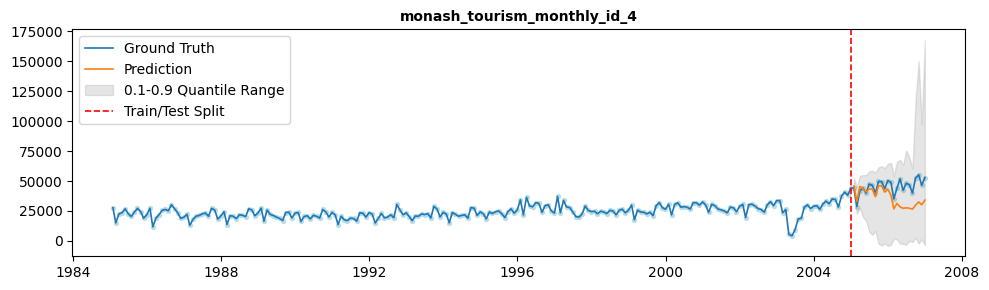


--------------------------------
PRE_DETREND: False, DO_DETREND: False, Z_SCALING: True, CONST: 0.01


GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

   item_id  mase_score
0        4    2.494826
1  AVERAGE    2.494826


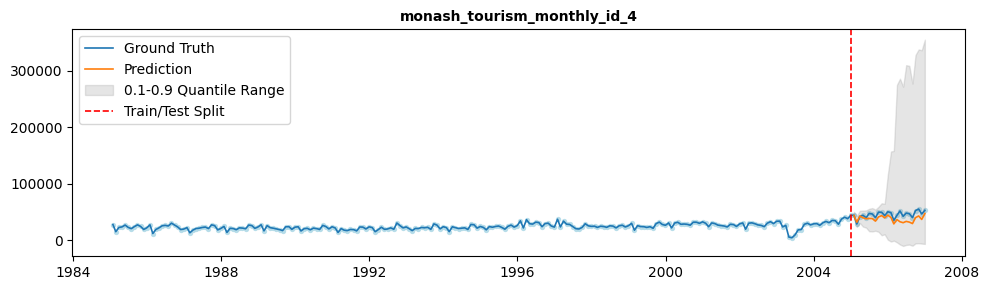


--------------------------------
PRE_DETREND: False, DO_DETREND: False, Z_SCALING: False, CONST: 0.01


GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

   item_id  mase_score
0        4    2.508565
1  AVERAGE    2.508565


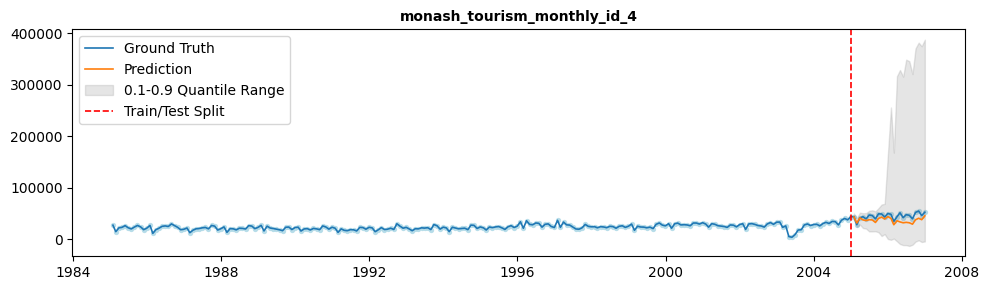

In [15]:
# Load and plot data
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)
tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
prediction_length = dataset_metadata[dataset_choice]['prediction_length']
tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[[num_time_series_subset]])]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

# plot_actual_ts(train_tsdf, test_tsdf_ground_truth)


# (Change here!!!) Feature engineering
# for (DO_DETREND, Z_SCALING) in [(True, True), (True, False), (False, True), (False, False)]:
CONST = 0.01
for (PRE_DETREND, DO_DETREND, Z_SCALING) in [(True, True, True), (True, True, False), (True, False, True), (True, False, False), (False, True, True), (False, True, False), (False, False, True), (False, False, False)]:

    print(f"\n--------------------------------\nPRE_DETREND: {PRE_DETREND}, DO_DETREND: {DO_DETREND}, Z_SCALING: {Z_SCALING}, CONST: {CONST}")
    selected_features = [
        
        PolynomialTrendFeature(pre_detrend=PRE_DETREND, 
                               do_detrend=DO_DETREND, 
                               z_scaling=Z_SCALING, 
                            #    constant_scale=CONST,
                               detrend_type="linear",
                            #    detrend_type="constant",
                               
                               degree=[6,7]),
        RunningIndexFeature(),
        CalendarFeature(),
        AutoSeasonalFeature(),
        # LinearTrendFeature(do_detrend=DO_DETREND, z_scaling=Z_SCALING), # Add this
        # QuadraticTrendFeature(do_detrend=DO_DETREND, z_scaling=Z_SCALING),
        # CubicTrendFeature(do_detrend=DO_DETREND, z_scaling=Z_SCALING),
        # QuarticTrendFeature(do_detrend=DO_DETREND, z_scaling=Z_SCALING),
        # AmplitudeModulationTrendFeature(),
    ]

    feature_transformer = FeatureTransformer(selected_features)
    train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)


    # Prediction
    from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode
    predictor = TabPFNTimeSeriesPredictor(
        tabpfn_mode=TabPFNMode.LOCAL,
    )
    pred = predictor.predict(train_tsdf, test_tsdf)

    # MASE
    final_results = quick_mase_evaluation(train_tsdf, test_tsdf_ground_truth, 
                                        pred.copy(), prediction_length,
                                        )
    # final_results,  train_tsdf.columns
    print(final_results)


    # Plotting
    from tabpfn_time_series.plot import plot_pred_and_actual_ts
    output_dir = root_output_dir / "patching_test"
    output_dir.mkdir(parents=True, exist_ok=True)
    # if DO_DETREND and Z_SCALING:
    plot_pred_and_actual_ts(pred, train_tsdf, test_tsdf_ground_truth, 
                            item_ids=list(train_tsdf.item_ids), show_points=True,
                            title=f"{dataset_choice}_id_{num_time_series_subset}",
                            # show_quantiles=False,
                            # save_path=output_dir / f"{dataset_choice.replace('/', '-')}.pdf"
                            )
    
    # fig = plt.figure(figsize=(6, 1.5))
    # for col in train_tsdf.columns:
    # #     if col == 'sin_#4':
    # #         plt.plot(np.array(train_tsdf[col]), alpha=1, label=col)
            
    # #     if col == 'target':
    # #         continue
    # #     elif col == 'year' or col=="running_index":
    # #         continue
    # #     elif "sin" in col or "cos" in col:
    # #         continue
    # #     print(col)
    #     if "sin" in col or "poly" in col:
    #         plt.plot(np.array(train_tsdf[col]), alpha=0.5, label=col)
    # plt.legend()
    # plt.show()

    



In [6]:
# train_tsdf[-10:]


In [4]:
# test_tsdf[-20:]

## Modulations

GPU 0:: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


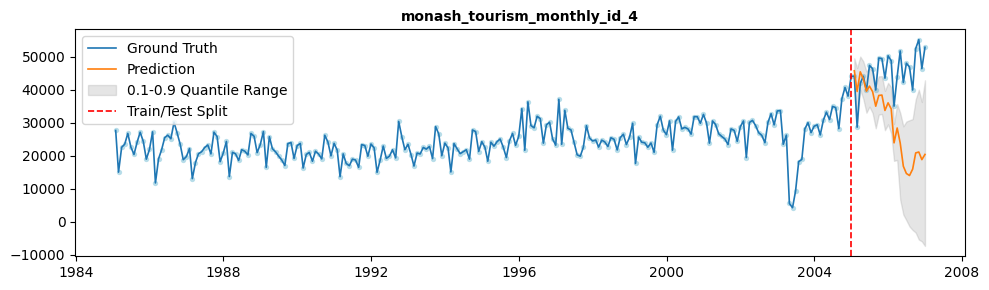

   item_id  mase_score
0        4    4.655923
1  AVERAGE    4.655923 0.1
amplitude_modulation_trend


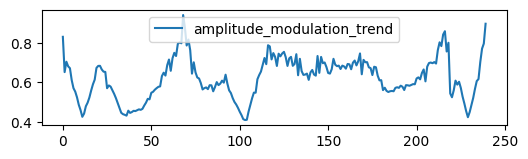

GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


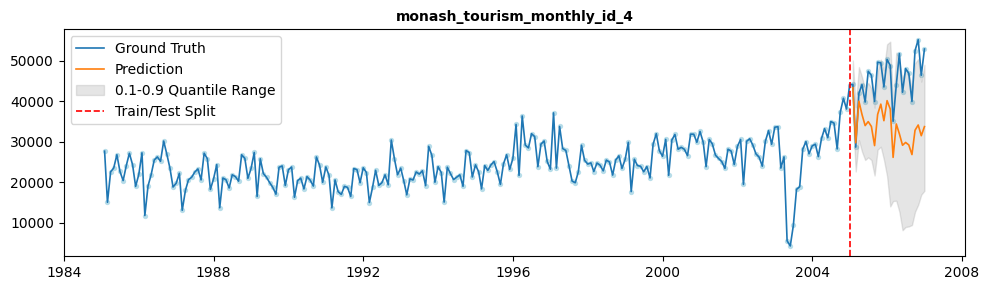

   item_id  mase_score
0        4    3.455224
1  AVERAGE    3.455224 0.2
amplitude_modulation_trend


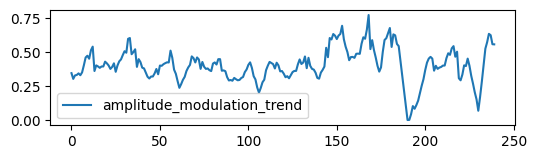

GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


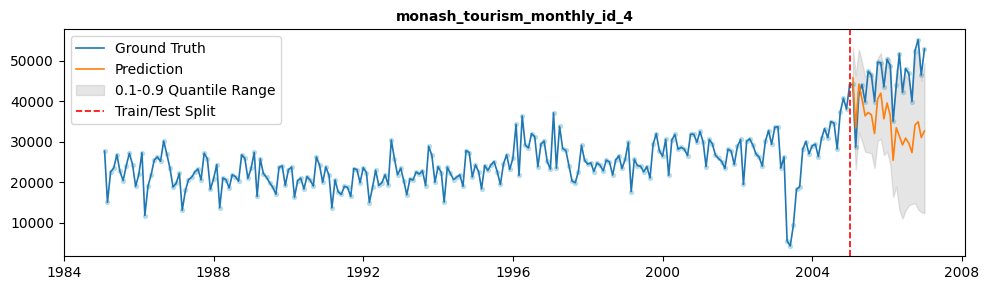

   item_id  mase_score
0        4    3.257448
1  AVERAGE    3.257448 0.3
amplitude_modulation_trend


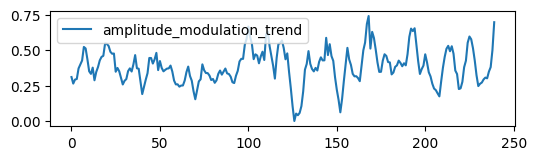

GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


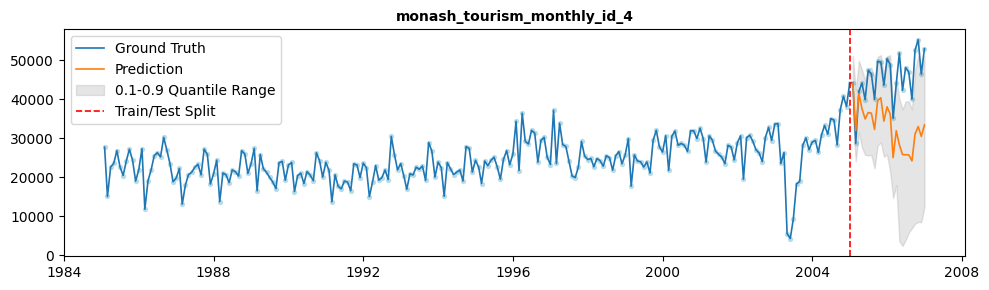

   item_id  mase_score
0        4    3.645164
1  AVERAGE    3.645164 0.4
amplitude_modulation_trend


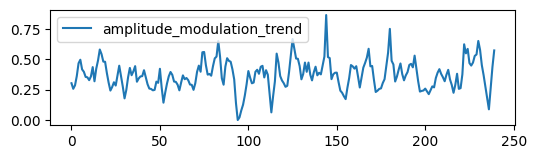

GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


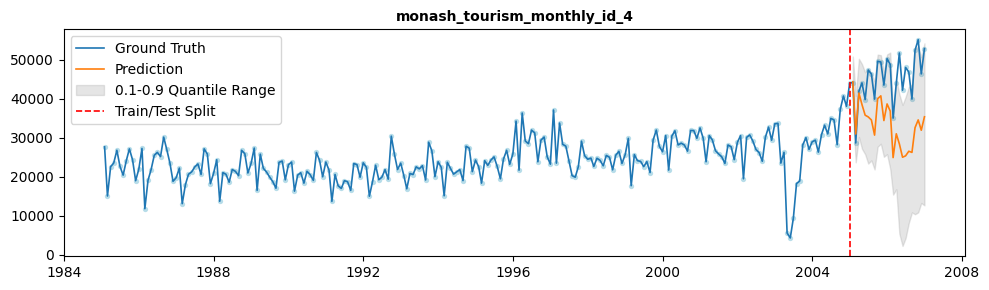

   item_id  mase_score
0        4    3.572958
1  AVERAGE    3.572958 0.5
amplitude_modulation_trend


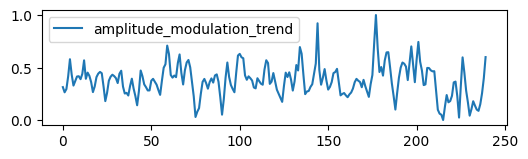

GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


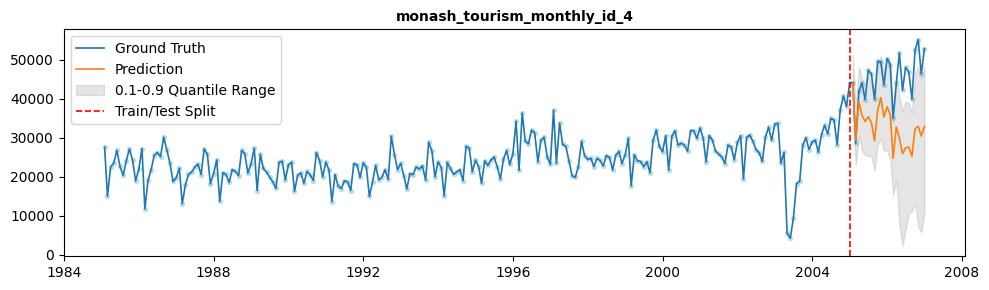

   item_id  mase_score
0        4    3.676749
1  AVERAGE    3.676749 0.6
amplitude_modulation_trend


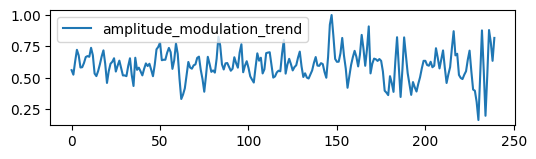

GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


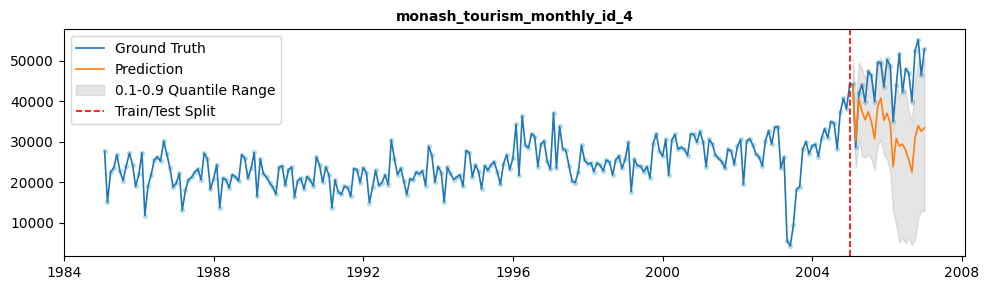

   item_id  mase_score
0        4    3.636934
1  AVERAGE    3.636934 0.7
amplitude_modulation_trend


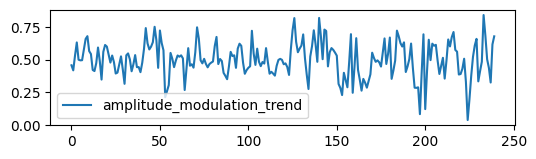

GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


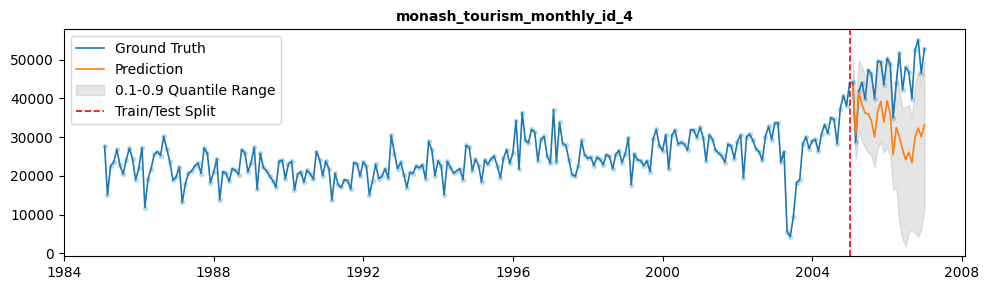

   item_id  mase_score
0        4    3.746324
1  AVERAGE    3.746324 0.8
amplitude_modulation_trend


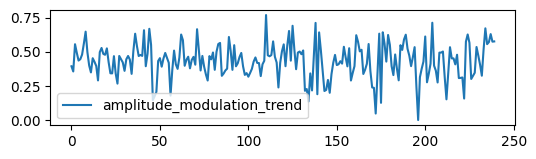

GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


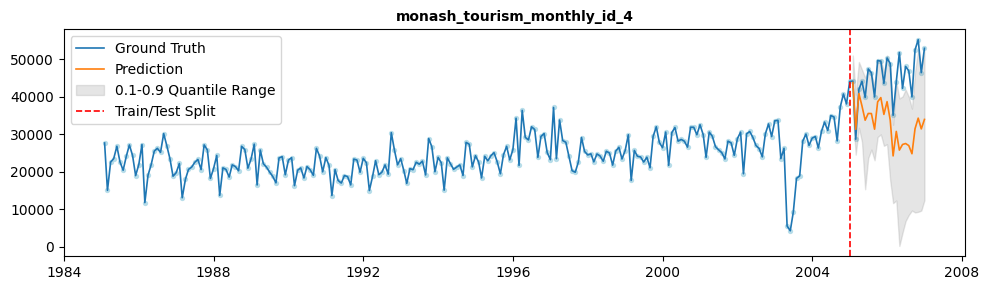

   item_id  mase_score
0        4    3.671266
1  AVERAGE    3.671266 0.9
amplitude_modulation_trend


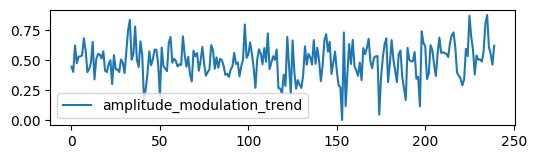

In [ ]:
# Load and plot data
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)
tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
prediction_length = dataset_metadata[dataset_choice]['prediction_length']
tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[[num_time_series_subset]])]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

# plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

for factor in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    # (Change here!!!) Feature engineering
    selected_features = [
        RunningIndexFeature(),
        CalendarFeature(),
        AutoSeasonalFeature(),
        AmplitudeModulationTrendFeature(k_max=int(len(train_tsdf)*factor)),
        # PolynomialTrendFeature(pre_detrend=True, 
        #                        do_detrend=True, 
        #                        z_scaling=False, 
        #                        detrend_type="linear",
        #                        degree=[2]),
    ]

    feature_transformer = FeatureTransformer(selected_features)
    train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)


    # Prediction
    from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode
    predictor = TabPFNTimeSeriesPredictor(
        tabpfn_mode=TabPFNMode.LOCAL,
    )
    pred = predictor.predict(train_tsdf, test_tsdf)

    
    # Plotting
    from tabpfn_time_series.plot import plot_pred_and_actual_ts
    output_dir = root_output_dir / "patching_test"
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_pred_and_actual_ts(pred, train_tsdf, test_tsdf_ground_truth, 
                            item_ids=list(train_tsdf.item_ids), show_points=True,
                            title=f"{dataset_choice}_id_{num_time_series_subset}",
                            # save_path=output_dir / f"{dataset_choice.replace('/', '-')}.pdf"
                            )
    # # MASE
    final_results = quick_mase_evaluation(train_tsdf, test_tsdf_ground_truth, 
                                        pred, prediction_length,
                                        )
    
    print(final_results, factor)
    
    fig = plt.figure(figsize=(6, 1.5))
    for col in train_tsdf.columns:
        if col == 'target':
            continue
        elif col == 'year' or col=="running_index":
            continue
        elif "sin" in col or "cos" in col:
            continue
        print(col)
        plt.plot(np.array(train_tsdf[col]), alpha=1, label=col)
        # plt.plot(np.array(train_tsdf[col]), alpha=0.5, label=col)
    plt.legend()
    plt.show()



In [3]:
np.linspace(1, 11, 3).astype(int)

array([ 1,  6, 11])

In [8]:
train_tsdf

target  running_index  year  second_of_minute_sin  \
item_id timestamp                                                        
4       1985-01-31  27693.0              0  1985                   0.0   
        1985-02-28  15075.0              1  1985                   0.0   
        1985-03-31  22602.0              2  1985                   0.0   
        1985-04-30  23530.0              3  1985                   0.0   
        1985-05-31  26817.0              4  1985                   0.0   
...                     ...            ...   ...                   ...   
        2004-08-31  28247.0            235  2004                   0.0   
        2004-09-30  37291.0            236  2004                   0.0   
        2004-10-31  40748.0            237  2004                   0.0   
        2004-11-30  38102.0            238  2004                   0.0   
        2004-12-31  44080.0            239  2004                   0.0   

                    second_of_minute_cos  minute_of_hour_sin  \
item_id timestamp                                              
4       1985-01-31                   1.0                 0.0   
        1985-02-28                   1.0                 0.0   
        1985-03-31                   1.0                 0.0   
        1985-04-30                   1.0                 0.0   
        1985-05-31                   1.0                 0.0   
...                                  ...                 ...   
        2004-08-31                   1.0                 0.0   
        2004-09-30                   1.0                 0.0   
        2004-10-31                   1.0                 0.0   
        2004-11-30                   1.0                 0.0   
        2004-12-31                   1.0                 0.0   

                    minute_of_hour_cos  hour_of_day_sin  hour_of_day_cos  \
item_id timestamp                                                          
4       1985-01-31                 1.0              0.0              1.0   
        1985-02-28                 1.0              0.0              1.0   
        1985-03-31                 1.0              0.0              1.0   
        1985-04-30                 1.0              0.0              1.0   
        1985-05-31                 1.0              0.0              1.0   
...                                ...              ...              ...   
        2004-08-31                 1.0              0.0              1.0   
        2004-09-30                 1.0              0.0              1.0   
        2004-10-31                 1.0              0.0              1.0   
        2004-11-30                 1.0              0.0              1.0   
        2004-12-31                 1.0              0.0              1.0   

                    day_of_week_sin  ...        sin_#0  cos_#0    sin_#1  \
item_id timestamp                    ...                                   
4       1985-01-31     1.224647e-16  ...  0.000000e+00     1.0  0.000000   
        1985-02-28     1.224647e-16  ...  8.660254e-01    -0.5  0.130526   
        1985-03-31    -2.449294e-16  ... -8.660254e-01    -0.5  0.258819   
        1985-04-30     8.660254e-01  ... -2.449294e-16     1.0  0.382683   
        1985-05-31    -8.660254e-01  ...  8.660254e-01    -0.5  0.500000   
...                             ...  ...           ...     ...       ...   
        2004-08-31     8.660254e-01  ...  8.660254e-01    -0.5 -0.608761   
        2004-09-30     1.224647e-16  ... -8.660254e-01    -0.5 -0.500000   
        2004-10-31    -2.449294e-16  ... -5.487656e-14     1.0 -0.382683   
        2004-11-30     8.660254e-01  ...  8.660254e-01    -0.5 -0.258819   
        2004-12-31    -8.660254e-01  ... -8.660254e-01    -0.5 -0.130526   

                      cos_#1    sin_#2    cos_#2        sin_#3  cos_#3  \
item_id timestamp                                                        
4       1985-01-31  1.000000  0.000000  1.000000  0.000000e+00     1.0   
        1985-02-28  0.991

In [4]:
import numpy as np
import pandas as pd


def amplitude_modulation(time_series_df: pd.DataFrame) -> np.ndarray:
    """
    Apply amplitude modulation to a univariate time series.

    Args:
        time_series_df (pd.DataFrame):
            DataFrame containing a single column of length T.

    Returns:
        np.ndarray:
            Augmented time series of length T.
    """
    # extract the raw values
    values = time_series_df.iloc[:, 0].to_numpy()
    T = values.shape[0]

    # 1. sample number of changepoints k ∈ {0,1,..,5}
    k = np.random.randint(0, 6)

    # 2. sample k unique changepoints in {1,..,T-1}
    if k > 0:
        change_points = np.random.choice(
            np.arange(1, T), size=k, replace=False
        )
        change_points = sorted(change_points.tolist())
    else:
        change_points = []

    # 3. build boundary vector c = [0, c1,..,ck, T]
    boundaries = [0] + change_points + [T]
    print(boundaries)

    # 4. sample amplitudes a ∼ N(1,1) for each knot (k+2 points)
    amplitudes = np.random.normal(loc=1.0, scale=1.0,
                                  size=len(boundaries))
    print(len(amplitudes))

    # 5. interpolate trend t over [0..T)
    trend = np.empty(T, dtype=float)
    for idx in range(len(boundaries) - 1):
        start, end = boundaries[idx], boundaries[idx + 1]
        a_start, a_end = amplitudes[idx], amplitudes[idx + 1]
        segment_length = end - start

        if segment_length > 0:
            # linear interpolation from a_start to a_end
            rel_pos = np.linspace(
                0, 1, num=segment_length, endpoint=False
            )
            trend[start:end] = a_start + (a_end - a_start) * rel_pos + start

    print(trend.shape)
    # 6. apply amplitude modulation: y_aug = y ⊙ t
    augmented_series = values * trend

    return augmented_series, trend


In [5]:
# # suppose df has one column "y" of length T
# df = pd.DataFrame({"y": np.sin(np.linspace(0, 2 * np.pi, 100))})
# y_aug, trend = amplitude_modulation(df)

# plt.plot(df.y)
# plt.plot(y_aug)
# plt.plot(trend)
# plt.show()


[ 1.  5.  8.  9.  2.  3.  4.  7.  2.  3.  1.  5.  6.  7.  9. 10. 11.  8.
  5. nan nan] [ 1.  5.  8.  9.  2.  3.  4.  7.  2.  3.  1.  5.  6.  7.  9. 10. 11.  8.
  5.] [ 1.  5.  8.  9.  2.  3.  4.  7.  2.  3.  1.  5.  6.  7.  9. 10. 11.  8.
  5.  5.  5.]


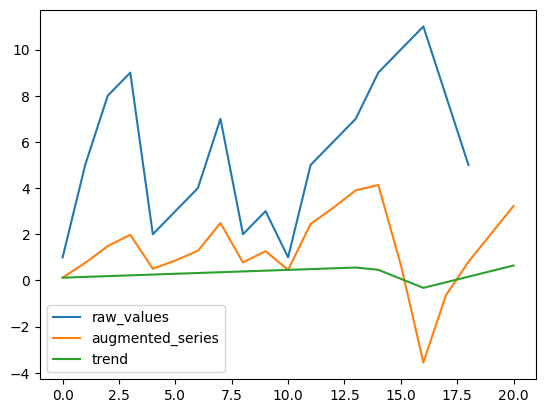

In [7]:
# extract the raw values
raw_values = np.array([1, 5, 8, 9, 2, 3, 4, 7, 2 ,3, 1, 5, 6, 7, 9, 10, 11, 8, 5, np.nan, np.nan])
values = raw_values[~np.isnan(raw_values)]
T = raw_values.shape[0]

# padded values: help me pad the values with nan values to the length of raw_values using the last value from values
padded_values = raw_values.copy()
padded_values[np.isnan(padded_values)] = values[-1]
print(raw_values, values, padded_values)



# 1. sample number of changepoints k ∈ {0,1,..,5}
k = np.random.randint(0, 6)

# 2. sample k unique changepoints in {1,..,T-1}
if k > 0:
    change_points = np.random.choice(
        np.arange(1, T), size=k, replace=False
    )
    change_points = sorted(change_points.tolist())
else:
    change_points = []

# 3. build boundary vector c = [0, c1,..,ck, T]
boundaries = [0] + change_points + [T]

# 4. sample amplitudes a ∼ N(1,1) for each knot (k+2 points)
amplitudes = np.random.normal(loc=1.0, scale=1.0,
                            size=len(boundaries))

# 5. interpolate trend t over [0..T)
trend = np.empty(T, dtype=float)
for idx in range(len(boundaries) - 1):
    start, end = boundaries[idx], boundaries[idx + 1]
    a_start, a_end = amplitudes[idx], amplitudes[idx + 1]
    segment_length = end - start

    if segment_length > 0:
        # linear interpolation from a_start to a_end
        rel_pos = np.linspace(
            0, 1, num=segment_length, endpoint=False
        )
        trend[start:end] = a_start + (a_end - a_start) * rel_pos

# 6. apply amplitude modulation: y_aug = y ⊙ t
augmented_series = padded_values * trend
plt.plot(raw_values, label="raw_values")
plt.plot(augmented_series, label="augmented_series")
plt.plot(trend, label="trend")
plt.legend()
plt.show()


## Detrend on only "y"

In [3]:
def detrend_tsdf(tsd, degree = 1):
    trends = []
    for item_id in tsdf.item_ids:
        values = np.array(tsdf.loc[item_id, 'target'])
        coeff_polynomial = np.polyfit(x=np.arange(len(values)), y=values, deg=degree)
        p = np.poly1d(coeff_polynomial)
        tsdf.loc[item_id, 'target'] = values - p(np.arange(len(values)))
        trend = p(np.arange(len(values)))
        trends.append(trend)
    return tsdf, trends


def retrend_tsdf(tsdf, trends, df_type="train"):
    index = 0
    tsdf = tsdf.copy()
    for item_id in tsdf.item_ids:
        
        if df_type == "train":
            values = np.array(tsdf.loc[item_id, 'target'])
            values = values + trends[index][:len(values)]
            tsdf.loc[item_id, 'target'] = values
        else:
            # tsdf = tsdf.columns.drop("time_stamp")
            for col in tsdf.columns:
                # if "time" not in col:
                # print(col)
                values = np.array(tsdf.loc[item_id, col])
                values = values + trends[index][-len(values):]
                tsdf.loc[item_id, col] = values
        index += 1
        
    return tsdf

detrending...


GPU 0:: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


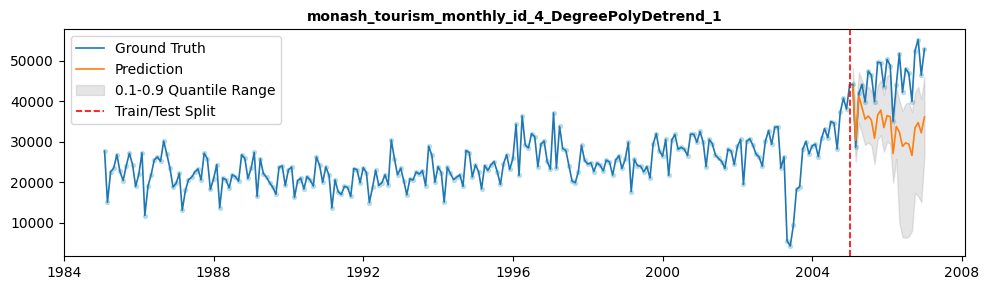

   item_id  mase_score
0        4    3.413441
1  AVERAGE    3.413441
detrending...


GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


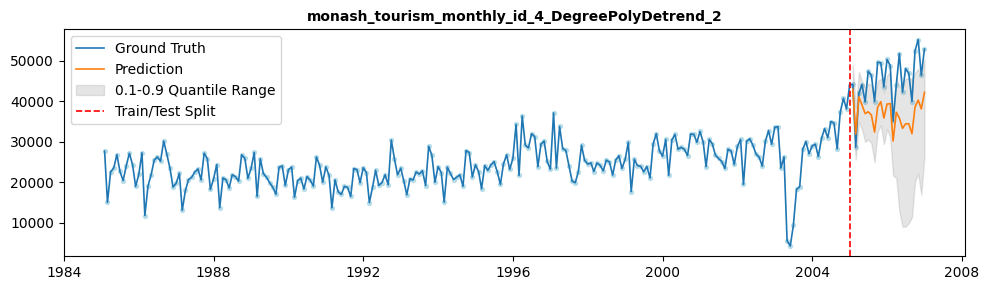

   item_id  mase_score
0        4    2.620247
1  AVERAGE    2.620247
detrending...


GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


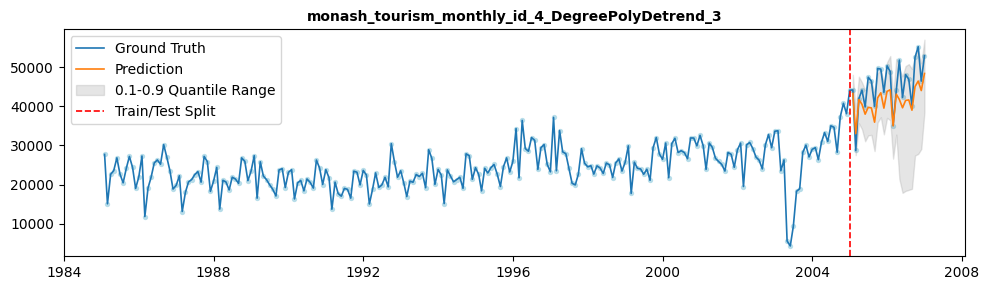

   item_id  mase_score
0        4    1.793017
1  AVERAGE    1.793017
detrending...


GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


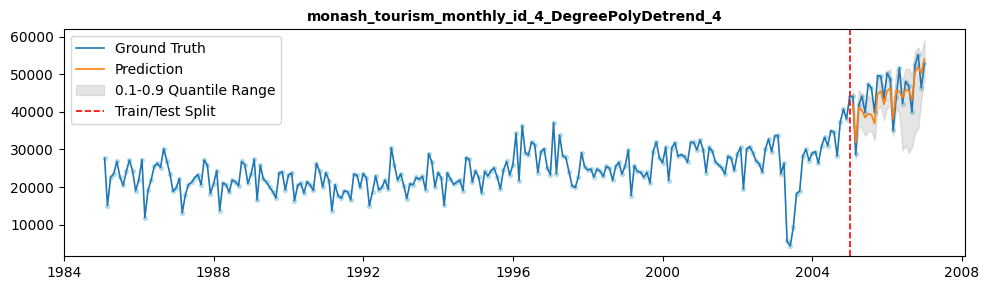

   item_id  mase_score
0        4    1.645584
1  AVERAGE    1.645584


In [4]:
from scipy.signal import detrend as scipy_detrend
from save_plot import plot_time_series
# from tabpfn_time_series.data_preparation import to_gluonts_univariate
# from autogluon.timeseries import TimeSeriesDataFrame
# from datasets import load_dataset



for degree in range(1, 5):
    # Load and plot data
    dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)
    tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
    prediction_length = dataset_metadata[dataset_choice]['prediction_length']
    # tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[:num_time_series_subset])]
    tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[[num_time_series_subset]])]

    ########################    Detrending    ########################    

    print("detrending...")

    tsdf, trends = detrend_tsdf(tsdf, degree=degree)
    # plot_time_series(tsdf, title="detrended tsdf")


    ########################                  ########################    


    train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
    test_tsdf = generate_test_X(train_tsdf, prediction_length)



    # Feature engineering
    PATCH = False
    if PATCH:
        selected_features = [
            RunningIndexFeature(),
            CalendarFeature(),
            AutoSeasonalFeature(),
            PatchingFeature(),
        ]
    else:
        selected_features = [
            RunningIndexFeature(),
            CalendarFeature(),
            AutoSeasonalFeature(),
        ]

    feature_transformer = FeatureTransformer(selected_features)
    train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)




    # Prediction
    from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode
    predictor = TabPFNTimeSeriesPredictor(
        tabpfn_mode=TabPFNMode.LOCAL,
    )
    pred = predictor.predict(train_tsdf, test_tsdf)


    # # Plotting
    from save_plot import plot_pred_and_actual_ts
    plot_train_tsdf = retrend_tsdf(train_tsdf, trends, df_type="train")
    plot_test_gt_tsdf = retrend_tsdf(test_tsdf_ground_truth, trends, df_type="train")
    plot_pred_tsdf = retrend_tsdf(pred, trends, df_type="pred")


    plot_pred_and_actual_ts(plot_pred_tsdf, plot_train_tsdf, plot_test_gt_tsdf, 
                            item_ids=list(plot_train_tsdf.item_ids), show_points=True,
                            title=f"{dataset_choice}_id_{num_time_series_subset}_DegreePolyDetrend_{degree}",
                            # save_path=output_dir / f"{dataset_choice.replace('/', '-')}.pdf"
                            )
    # plt.plot(trends[0])


    final_results = quick_mase_evaluation(plot_train_tsdf, 
                                        plot_test_gt_tsdf, 
                                        plot_pred_tsdf, prediction_length,
                                        )
    print(final_results)





## Patched TabPFNTS

GPU 0:: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


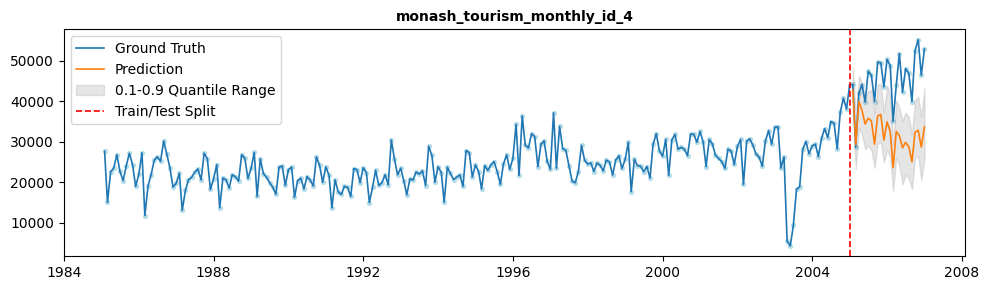

(   item_id  mase_score
 0        4    3.784263
 1  AVERAGE    3.784263,
 Index(['lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38',
        'lag_39', 'lag_40', 'lag_41', 'lag_42', 'lag_43', 'lag_44', 'lag_45',
        'lag_46', 'lag_47', 'lag_48', 'lag_49', 'lag_50', 'lag_51'],
       dtype='object'),
 264)

In [19]:
# Load and plot data
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)
tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
prediction_length = dataset_metadata[dataset_choice]['prediction_length']
tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[[num_time_series_subset]])]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

# Feature engineering
PATCH = True
if PATCH:
    selected_features = [
        RunningIndexFeature(),
        CalendarFeature(),
        AutoSeasonalFeature(),
        PatchingFeature(),
    ]
else:
    selected_features = [
        RunningIndexFeature(),
        CalendarFeature(),
        AutoSeasonalFeature(),
    ]

feature_transformer = FeatureTransformer(selected_features)
train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)


# Prediction
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode
predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.LOCAL,
)
pred = predictor.predict(train_tsdf, test_tsdf)


# Plotting
from tabpfn_time_series.plot import plot_pred_and_actual_ts
output_dir = root_output_dir / "patching_test"
output_dir.mkdir(parents=True, exist_ok=True)
plot_pred_and_actual_ts(pred, train_tsdf, test_tsdf_ground_truth, 
                        item_ids=list(train_tsdf.item_ids), show_points=True,
                        title=f"{dataset_choice}_id_{num_time_series_subset}",
                        # save_path=output_dir / f"{dataset_choice.replace('/', '-')}.pdf"
                        )

# MASE
final_results = quick_mase_evaluation(train_tsdf, test_tsdf_ground_truth, 
                                      pred, prediction_length,
                                      )
# print(train_tsdf.columns[-40:])
final_results, train_tsdf.columns[-20:], len(test_tsdf_ground_truth)
# , train_tsdf.head()


In [38]:
train_tsdf.columns

Index(['target', 'running_index', 'year', 'second_of_minute_sin',
       'second_of_minute_cos', 'minute_of_hour_sin', 'minute_of_hour_cos',
       'hour_of_day_sin', 'hour_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'day_of_month_sin', 'day_of_month_cos',
       'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin',
       'week_of_year_cos', 'month_of_year_sin', 'month_of_year_cos', 'sin_#0',
       'cos_#0', 'sin_#1', 'cos_#1', 'sin_#2', 'cos_#2', 'sin_#3', 'cos_#3',
       'sin_#4', 'cos_#4', 'lag_0', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25',
       'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31', 'lag_32',
       'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39',
       'lag_40', 'lag_41', 'lag_42', 'lag_43', 'lag_44',

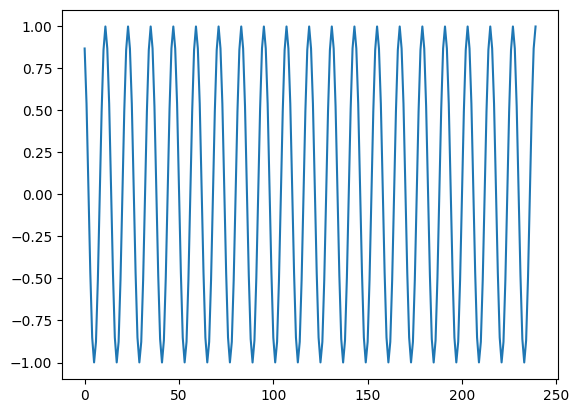

In [46]:
import numpy as np

# plt.plot(np.array(train_tsdf.target))
plt.plot(np.array(train_tsdf['day_of_year_cos']))
# plt.plot(np.array(train_tsdf['sin_#1']))
# plt.plot(np.array(train_tsdf['sin_#2']))
# plt.plot(np.array(train_tsdf['sin_#3']))

# values









In [26]:
import numpy as np

values = np.array(train_tsdf.target)
values


array([27693., 15075., 22602., 23530., 26817., 22696., 20433., 24152.,
       27170., 24372., 19000., 21954., 27284., 11806., 19115., 21851.,
       25528., 26275., 25191., 30191., 27015., 23505., 18847., 19782.,
       22235., 13104., 17994., 20656., 21262., 22526., 23313., 20602.,
       27186., 25840., 18243., 20888., 24378., 13723., 21074., 20649.,
       18615., 21867., 21413., 20292., 26802., 25936., 20987., 23427.,
       27377., 16511., 25811., 22174., 21233., 19955., 18770., 17074.,
       23715., 24049., 19224., 23132., 23787., 16323., 20438., 21054.,
       18377., 21420., 20546., 19087., 26256., 24198., 20004., 23804.,
       21725., 13691., 20604., 17696., 17021., 19006., 18756., 16521.,
       23412., 23138., 19898., 23596., 22429., 15023., 18782., 22971.,
       19245., 19903., 21852., 19391., 30440., 25762., 21876., 23508.,
       20270., 16919., 20864., 20579., 22562., 22044., 22853., 19182.,
       28883., 26664., 20034., 23868., 22414., 15128., 23733., 22186.,
      

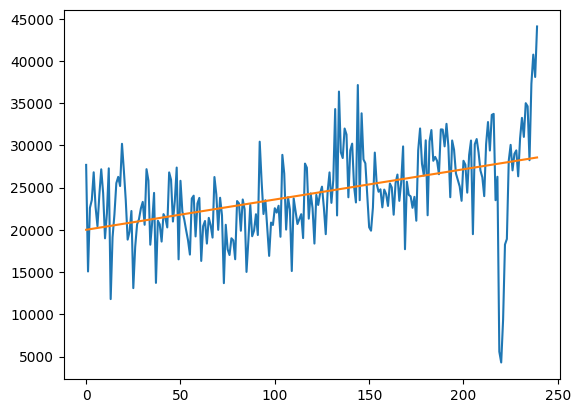

[   35.81152103 20012.08990318] (240,) (240,) (240,)


In [ ]:
import numpy as np

def get_linear_trend(df):
    values = np.array(df.target)
    coeff_linear = np.polyfit(x=np.arange(len(values)), y=values, deg=1)
    p = np.poly1d(coeff_linear)
    df['linear_trend'] = p(np.arange(len(values)))
    return df



values = np.array(train_tsdf.target)


coeff_linear = np.polyfit(x=np.arange(len(values)), y=values, deg=1)
p = np.poly1d(coeff_linear)

plt.plot(values)
plt.plot(p(np.arange(len(values))))
plt.show()

print(coeff_linear, np.arange(len(values)).shape, values.shape, p(np.arange(len(values))).shape)

# print(np.arange(len(values)).shape, values.shape)





# June 19 2025

In [15]:
# !python script_lagpatch_exp_v1.py --patch --window_size 2

In [10]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
df.head()
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

In [14]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=60,
    hyperparameters={
      "AutoARIMA": {},
      "AutoETS": {},
   },
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/home/turbo/rosenyu/Github/tabpfn-time-series-exp/tabpfn_time_series/experimental/patching/AutogluonModels/ag-20250619_161147'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.18
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #63~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 22 19:00:15 UTC 2
CPU Count:          32
GPU Count:          2
Memory Avail:       117.34 GB / 125.55 GB (93.5%)
Disk Space Avail:   159.07 GB / 1830.21 GB (8.7%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'AutoARIMA': {}, 'AutoETS': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection'

In [15]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: AutoETS


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  631.889598  582.874079  599.700100  611.832845   
        1750-01-30 05:00:00  559.750830  510.489302  527.399773  539.593412   
        1750-01-30 06:00:00  519.235476  469.729161  486.723662  498.977893   
        1750-01-30 07:00:00  486.973364  437.223465  454.301584  466.616109   
        1750-01-30 08:00:00  464.697366  414.705071  431.866399  444.240924   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  622.199828  631.889598  641.579368  651.946351   
        1750-01-30 05:00:00  550.012427  559.750830  569.489233  579.908248   
        1750-01-30 06:00:00  509.448682  519.235476  529.022271  539.493059   
        1750-01-30 07:00:00  477.138416  486.973364  496.808312  507.330619   
        1750-01-30 08:00:00  454.814500  464.697366  474.580233  485.153808   

                                    0.8         0.9  
item_id timestamp                                    
H1      1750-01-30 04:00:00  664.079096  680.905116  
        1750-01-30 05:00:00  592.101888  609.012359  
        1750-01-30 06:00:00  551.747291  568.741792  
        1750-01-30 07:00:00  519.645144  536.723263  
        1750-01-30 08:00:00  497.528333  514.689661

In [16]:
predictor.delete_models()

AttributeError: 'TimeSeriesPredictor' object has no attribute 'delete_models'

In [1]:
def quick_mase_evaluation(train_tsdf, test_tsdf_ground_truth, pred, prediction_length):
    """
    Compute MASE scores for each item_id and overall average.
    
    Returns:
        pd.DataFrame: DataFrame with columns ['item_id', 'mase_score']
                     Last row contains average with item_id='AVERAGE'
    """
    from autogluon.timeseries.metrics.point import MASE
    from autogluon.timeseries.utils.datetime import get_seasonality
    import pandas as pd
    
    mase_results = []
    
    # Loop over each item_id and calculate MASE score
    for item_id, df_item in train_tsdf.groupby(level="item_id"):
        mase_computer = MASE()
        mase_computer.clear_past_metrics()
        
        pred["mean"] = pred["target"]
        
        mase_computer.save_past_metrics(
            data_past=train_tsdf.loc[[item_id]],
            seasonal_period=get_seasonality(train_tsdf.freq),
        )
        
        mase_score = mase_computer.compute_metric(
            data_future=test_tsdf_ground_truth.loc[[item_id]].slice_by_timestep(
                -prediction_length - 1, -1
            ),
            predictions=pred.loc[[item_id]],
        )
        
        mase_results.append({
            'item_id': item_id,
            'mase_score': mase_score
        })
    
    # Create DataFrame with individual results
    results_df = pd.DataFrame(mase_results)
    
    # Add average row
    average_mase = results_df['mase_score'].mean()
    average_row = pd.DataFrame({
        'item_id': ['AVERAGE'],
        'mase_score': [average_mase]
    })
    
    # Combine results
    final_results = pd.concat([results_df, average_row], ignore_index=True)
    
    return final_results

# Example execusion

length test_tsdf: 384


GPU 0:: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


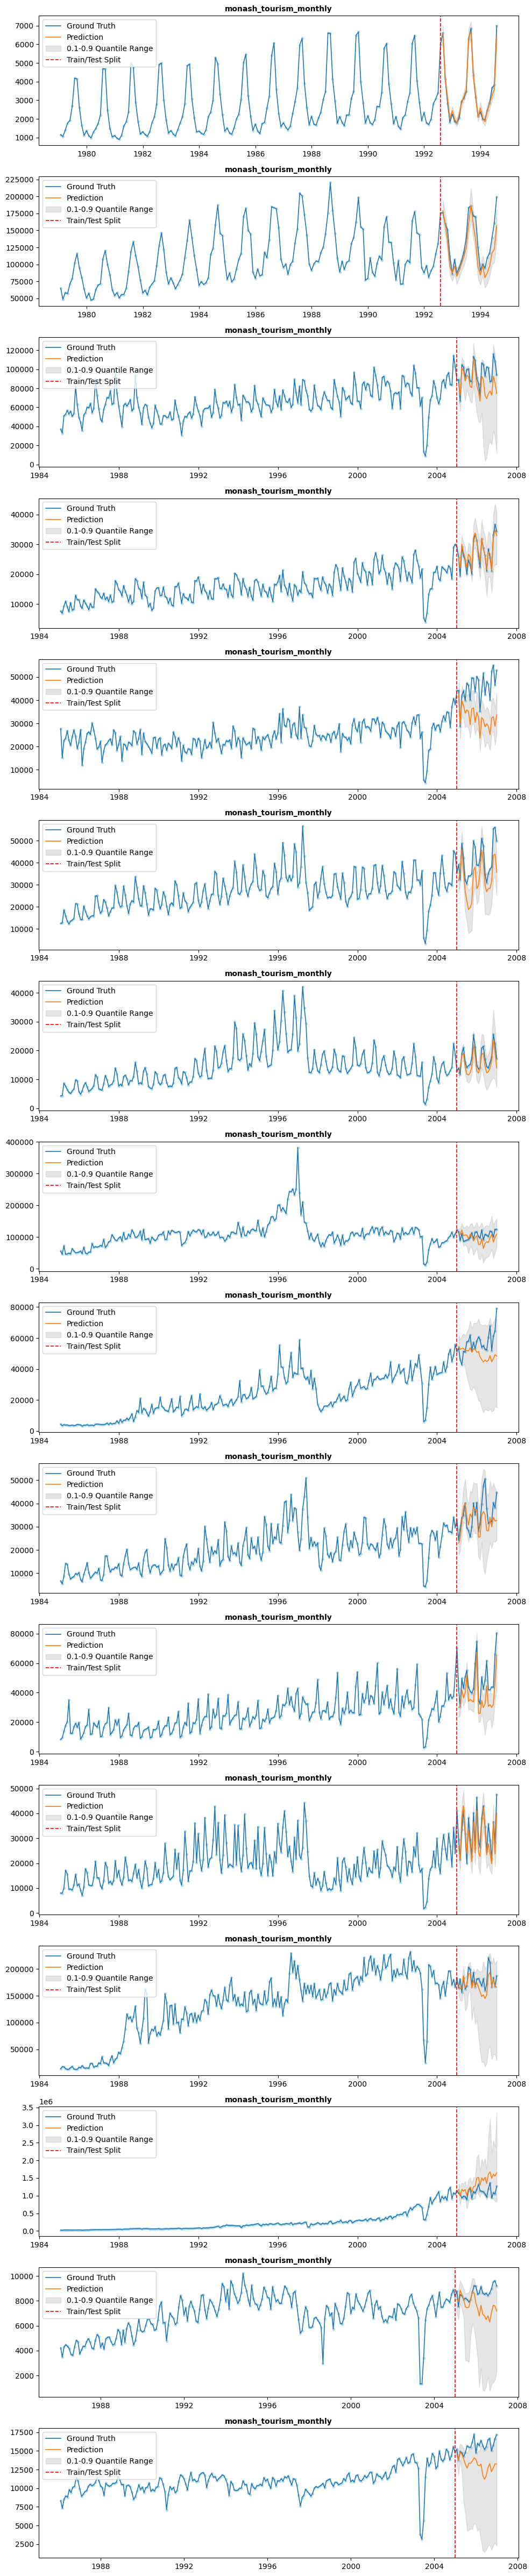

    item_id  mase_score
0         0    4.546543
1         1    1.739267
2         2    1.985938
3         3    2.014956
4         4    3.788427
5         5    2.389483
6         6    1.292715
7         7    0.624174
8         8    1.301730
9         9    1.414802
10       10    2.694726
11       11    2.571339
12       12    0.812361
13       13    4.679029
14       14    1.376507
15       15    2.157260
16  AVERAGE    2.211828


In [2]:
import os
from dotenv import load_dotenv
from pathlib import Path

load_dotenv()


from datasets import load_dataset
from autogluon.timeseries import TimeSeriesDataFrame
from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X

root_output_dir = Path("plots")

root_output_dir.mkdir(parents=True, exist_ok=True)

dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24}, # {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
    "electricity_15min": {"prediction_length": 48},
}

dataset_choice = "monash_tourism_monthly"
num_time_series_subset = 16

# for binary in range(2):
#     if binary<1:
#         PATHC = True
#     else:
#         PATHC = False
PATHC = True


dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
prediction_length = dataset_metadata[dataset_choice]['prediction_length']

tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[:num_time_series_subset])]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

from tabpfn_time_series.plot import plot_actual_ts
import matplotlib.pyplot as plt

print(f"length test_tsdf: {len(test_tsdf)}")

# plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

from tabpfn_time_series import FeatureTransformer
from tabpfn_time_series.features import (
    RunningIndexFeature,
    CalendarFeature,
    AutoSeasonalFeature,
)
from patch_features import PatchingFeature


if PATHC:
    selected_features = [
        RunningIndexFeature(),
        CalendarFeature(),
        AutoSeasonalFeature(),
        PatchingFeature(),
    ]
else:
    selected_features = [
        RunningIndexFeature(),
        CalendarFeature(),
        AutoSeasonalFeature(),
    ]

feature_transformer = FeatureTransformer(selected_features)

train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)

# train_tsdf
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.LOCAL,
)

pred = predictor.predict(train_tsdf, test_tsdf)

from tabpfn_time_series.plot import plot_pred_and_actual_ts
output_dir = root_output_dir / "patching_test"
output_dir.mkdir(parents=True, exist_ok=True)
plot_pred_and_actual_ts(pred, train_tsdf, test_tsdf_ground_truth, 
                        item_ids=list(train_tsdf.item_ids), show_points=True,
                        title=f"{dataset_choice}",
                        save_path=output_dir / f"{dataset_choice.replace('/', '-')}.pdf"
                        )


final_results = quick_mase_evaluation(train_tsdf, test_tsdf_ground_truth, 
                                      pred, prediction_length,
                                      )



print(final_results)



In [5]:
len(pred)/48

8.0

In [ ]:
    # from tabpfn_time_series.plot import plot_pred_and_actual_ts

    # # plot_pred_and_actual_ts(
    # #     train=train_tsdf,
    # #     test=test_tsdf_ground_truth,
    # #     pred=pred,
    # # )

    # from autogluon.timeseries.metrics.point import MASE
    # from autogluon.timeseries.utils.datetime import get_seasonality


    # MASEComputer = MASE()
    # MASEComputer.clear_past_metrics()

    # pred["mean"] = pred["target"]


    # MASEComputer.save_past_metrics(
    #     data_past=train_tsdf,
    #     seasonal_period=get_seasonality(train_tsdf.freq),
    # )

    # clean_mase = MASEComputer.compute_metric(
    #     data_future=test_tsdf_ground_truth.slice_by_timestep(-prediction_length -1, -1),
    #     predictions=pred,
    # )

    
    # print(f"ID: {id_}, PATHC: {PATHC}, clean_mase: {clean_mase}")

In [9]:
# tsdf.loc[0]

In [6]:
for item_id in tsdf.item_ids:
    print(tsdf.loc[item_id])
#     # break

               target
timestamp            
1979-01-31  1149.8700
1979-02-28  1053.8002
1979-03-31  1388.8798
1979-04-30  1783.3702
1979-05-31  1921.0252
...               ...
1994-03-31  2466.3100
1994-04-30  2851.7150
1994-05-31  3671.8050
1994-06-30  3806.7800
1994-07-31  6995.0500

[187 rows x 1 columns]
                 target
timestamp              
1979-01-31   65072.3700
1979-02-28   48612.2000
1979-03-31   58452.5900
1979-04-30   57033.9700
1979-05-31   71498.9500
...                 ...
1994-03-31  109861.6957
1994-04-30  116636.7445
1994-05-31  139426.5233
1994-06-30  161014.9254
1994-07-31  199405.1160

[187 rows x 1 columns]
              target
timestamp           
1985-01-31   37047.0
1985-02-28   32836.0
1985-03-31   51094.0
1985-04-30   52629.0
1985-05-31   56884.0
...              ...
2006-08-31   86872.0
2006-09-30   87775.0
2006-10-31  116104.0
2006-11-30  108333.0
2006-12-31   93932.0

[264 rows x 1 columns]
             target
timestamp          
1985-01-31   7611

In [11]:
train_tsdf.loc[[0]]

target  running_index  year  second_of_minute_sin  \
item_id timestamp                                                          
0       1979-01-31  1149.8700              0  1979                   0.0   
        1979-02-28  1053.8002              1  1979                   0.0   
        1979-03-31  1388.8798              2  1979                   0.0   
        1979-04-30  1783.3702              3  1979                   0.0   
        1979-05-31  1921.0252              4  1979                   0.0   
...                       ...            ...   ...                   ...   
        1992-03-31  1979.1052            158  1992                   0.0   
        1992-04-30  2824.2600            159  1992                   0.0   
        1992-05-31  3076.5050            160  1992                   0.0   
        1992-06-30  3402.5850            161  1992                   0.0   
        1992-07-31  5985.8300            162  1992                   0.0   

                    second_of_minute_cos  minute_of_hour_sin  \
item_id timestamp                                              
0       1979-01-31                   1.0                 0.0   
        1979-02-28                   1.0                 0.0   
        1979-03-31                   1.0                 0.0   
        1979-04-30                   1.0                 0.0   
        1979-05-31                   1.0                 0.0   
...                                  ...                 ...   
        1992-03-31                   1.0                 0.0   
        1992-04-30                   1.0                 0.0   
        1992-05-31                   1.0                 0.0   
        1992-06-30                   1.0                 0.0   
        1992-07-31                   1.0                 0.0   

                    minute_of_hour_cos  hour_of_day_sin  hour_of_day_cos  \
item_id timestamp                                                          
0       1979-01-31                 1.0              0.0              1.0   
        1979-02-28                 1.0              0.0              1.0   
        1979-03-31                 1.0              0.0              1.0   
        1979-04-30                 1.0              0.0              1.0   
        1979-05-31                 1.0              0.0              1.0   
...                                ...              ...              ...   
        1992-03-31                 1.0              0.0              1.0   
        1992-04-30                 1.0              0.0              1.0   
        1992-05-31                 1.0              0.0              1.0   
        1992-06-30                 1.0              0.0              1.0   
        1992-07-31                 1.0              0.0              1.0   

                    day_of_week_sin  ...  lag_42  lag_43  lag_44  lag_45  \
item_id timestamp                    ...                                   
0       1979-01-31     8.660254e-01  ...     NaN     NaN     NaN     NaN   
        1979-02-28     8.660254e-01  ...     NaN     NaN     NaN     NaN   
        1979-03-31    -8.660254e-01  ...     NaN     NaN     NaN     NaN   
        1979-04-30     0.000000e+00  ...     NaN     NaN     NaN     NaN   
        1979-05-31     1.224647e-16  ...     NaN     NaN     NaN     NaN   
...                             ...  ...     ...     ...     ...     ...   
        1992-03-31     8.660254e-01  ...     NaN     NaN     NaN     NaN   
        1992-04-30     1.224647e-16  ...     NaN     NaN     NaN     NaN   
        1992-05-31    -2.449294e-16  ...     NaN     NaN     NaN     NaN   
        1992-06-30     8.660254e-01  ...     NaN     NaN     NaN     NaN   
        1992-07-31    -8.660254e-01  ...     NaN     NaN     NaN     NaN   

                    lag_46  lag_47  lag_48  lag_49  lag_50  lag_51  
item_id timestamp                                                   
0       1979-01-31     NaN     NaN     NaN     NaN     NaN     NaN  
        1979-02-

## Pytest and make this a MASE block

In [13]:
def quick_mase_evaluation(train_tsdf, test_tsdf_ground_truth, pred, prediction_length):
    """
    Compute MASE scores for each item_id and overall average.
    
    Returns:
        pd.DataFrame: DataFrame with columns ['item_id', 'mase_score']
                     Last row contains average with item_id='AVERAGE'
    """
    from autogluon.timeseries.metrics.point import MASE
    from autogluon.timeseries.utils.datetime import get_seasonality
    import pandas as pd
    
    mase_results = []
    
    for item_id, df_item in train_tsdf.groupby(level="item_id"):
        mase_computer = MASE()
        mase_computer.clear_past_metrics()
        
        pred["mean"] = pred["target"]
        
        mase_computer.save_past_metrics(
            data_past=train_tsdf.loc[[item_id]],
            seasonal_period=get_seasonality(train_tsdf.freq),
        )
        
        mase_score = mase_computer.compute_metric(
            data_future=test_tsdf_ground_truth.loc[[item_id]].slice_by_timestep(
                -prediction_length - 1, -1
            ),
            predictions=pred.loc[[item_id]],
        )
        
        mase_results.append({
            'item_id': item_id,
            'mase_score': mase_score
        })
    
    # Create DataFrame with individual results
    results_df = pd.DataFrame(mase_results)
    
    # Add average row
    average_mase = results_df['mase_score'].mean()
    average_row = pd.DataFrame({
        'item_id': ['AVERAGE'],
        'mase_score': [average_mase]
    })
    
    # Combine results
    final_results = pd.concat([results_df, average_row], ignore_index=True)
    
    return final_results

4.546542831234312
1.7392667481846884
1.9859381152346838
2.0149562592229135
3.7884265851217207
2.389482691689325
1.292715133471149
0.6241737971834398
1.3017298707567366
1.4148022383629375
2.694725729581439
2.571339216798698
0.8123609192349441
4.679028992775898
1.3765069897183786
2.1572598776560254


In [16]:
import numpy as np
MASEComputer = MASE()
MASEComputer.clear_past_metrics()

MASEComputer.save_past_metrics(
        data_past=train_tsdf,
        seasonal_period=get_seasonality(train_tsdf.freq),
    )

y_true, y_pred = MASEComputer._get_point_forecast_score_inputs(data_future=test_tsdf_ground_truth.slice_by_timestep(-prediction_length -1, -1),
                                              predictions=pred)
y_true, y_pred = y_true.to_numpy(), y_pred.to_numpy()

errors = np.abs(y_true - y_pred).reshape([-1, MASEComputer.prediction_length])
print(y_true.shape, y_pred.shape)
print(errors.shape)

print(MASEComputer._past_abs_seasonal_error.to_numpy().shape
      )



(384,) (384,)
(384, 1)
(16,)


In [19]:
y_true

array([   5985.83   ,    6611.115  ,    4150.2395 ,    2841.     ,
          1813.44   ,    2261.08   ,    1873.605  ,    1772.84   ,
          2049.565  ,    2932.265  ,    3113.255  ,    3461.505  ,
          6265.74   ,    6857.8    ,    4346.09   ,    3154.73   ,
          2142.21   ,    2375.725  ,    1981.11   ,    1959.865  ,
          2466.31   ,    2851.715  ,    3671.805  ,    3806.78   ,
        175490.2    ,  176215.2    ,  160025.7    ,  150995.5    ,
        112002.6    ,   85668.59   ,  107283.1    ,   86953.77   ,
         95141.96   ,  104902.6    ,  117794.5    ,  139187.5    ,
        183571.9    ,  185953.     ,  171384.6    ,  169834.5    ,
        125275.4    ,   90986.6    ,  100422.4502 ,   94333.93611,
        109861.6957 ,  116636.7445 ,  139426.5233 ,  161014.9254 ,
         88651.     ,   89162.     ,   66728.     ,  104864.     ,
        102253.     ,   91564.     ,   99782.     ,  100335.     ,
         87455.     ,   87126.     ,  113382.     ,  109339.  

In [18]:
MASEComputer._past_abs_seasonal_error.to_numpy()

array([  190.03671987, 10836.48635762,  9156.21929825,  2207.59649123,
        3522.30701754,  4040.85526316,  2867.75438596, 27791.5745614 ,
        6002.80701754,  4393.52631579,  4653.8377193 ,  4365.12719298,
       23265.47368421, 60533.22807018,   872.11305556,  1110.57740741])

In [ ]:
MASEComputer

In [13]:
print(MASEComputer._past_squared_seasonal_error.to_numpy().shape)

AttributeError: 'MASE' object has no attribute '_past_squared_seasonal_error'

In [8]:
seMASEComputerlf._safemean(errors / MASEComputer._past_abs_seasonal_error.to_numpy()[:, None])